In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from functools import reduce
import seaborn as sns
from typing import List

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler,Bucketizer
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, expr
from pyspark.sql.types import *

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab_1_SOBD") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
directory_path = "data/"

selected_file = 'itineraries.csv'

# Чтение выбранного файла и создание DataFrame
dataframe = spark.read.csv(os.path.join(directory_path, selected_file), header=True, inferSchema=True, sep=',')

# Вывод первых строк DataFrame
dataframe.limit(5).toPandas().head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,9ca0e81111c683bec1012473feefd28f,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H29M,0,False,False,...,1650223560,2022-04-17T15:26:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,8940,947,coach
1,98685953630e772a098941b71906592b,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650200400,2022-04-17T09:00:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9000,947,coach
2,98d90cbc32bfbb05c2fc32897c7c1087,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650218700,2022-04-17T14:05:00.000-04:00,BOS,ATL,Delta,DL,Boeing 757-200,9000,947,coach
3,969a269d38eae583f455486fa90877b4,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H32M,0,False,False,...,1650227460,2022-04-17T16:31:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9120,947,coach
4,980370cf27c89b40d2833a1d5afc9751,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H34M,0,False,False,...,1650213180,2022-04-17T12:33:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9240,947,coach


In [3]:
dataframe.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: s

In [4]:
dataframe.agg(*(countDistinct(col(c)).alias(c) for c in dataframe.columns)).toPandas()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,594234,3,61,16,16,4574,1307,3,2,2,...,481254,513130,3143,3133,98,98,3840,48739,6455,37


In [5]:
dataframe = dataframe.select('startingAirport', 'destinationAirport', 'isNonStop',
                    'isBasicEconomy', 'isRefundable', 'baseFare', 'totalFare', 
                    'seatsRemaining', 'totalTravelDistance', 'travelDuration')
# Извлечение часов и минут из travelDuration
dataframe = dataframe.withColumn("hours", expr("CAST(SPLIT(SUBSTRING(travelDuration, 3), 'H')[0] AS INT)"))
dataframe = dataframe.withColumn("minutes", expr("CAST(SPLIT(SPLIT(SUBSTRING(travelDuration, 3), 'H')[1], 'M')[0] AS INT)"))

# Преобразование в минуты
dataframe = dataframe.withColumn("travelDuration", expr("hours * 60 + minutes"))
dataframe = dataframe.drop("hours", "minutes")

dataframe.limit(5).toPandas()


,startingAirport,destinationAirport,isNonStop,isBasicEconomy,isRefundable,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDuration
0,ATL,BOS,True,False,False,217.67,248.6,9,947,149
1,ATL,BOS,True,False,False,217.67,248.6,4,947,150
2,ATL,BOS,True,False,False,217.67,248.6,9,947,150
3,ATL,BOS,True,False,False,217.67,248.6,8,947,152
4,ATL,BOS,True,False,False,217.67,248.6,9,947,154


In [6]:
dataframe.printSchema()

root
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- travelDuration: integer (nullable = true)



In [7]:
# Вывод количества строк до удаления пустых значений
dataframe.count()

1047402

In [8]:
# Вывод количества уникальных значений
dataframe.agg(*(countDistinct(col(c)).alias(c) for c in dataframe.columns)).show()

+---------------+------------------+---------+--------------+------------+--------+---------+--------------+-------------------+--------------+
|startingAirport|destinationAirport|isNonStop|isBasicEconomy|isRefundable|baseFare|totalFare|seatsRemaining|totalTravelDistance|travelDuration|
+---------------+------------------+---------+--------------+------------+--------+---------+--------------+-------------------+--------------+
|             16|                16|        2|             2|           2|    7948|    14763|            11|               2181|          1269|
+---------------+------------------+---------+--------------+------------+--------+---------+--------------+-------------------+--------------+



In [9]:
# Удаление строк с пропущенными значениями
cleaned_dataframe = dataframe.dropna()

# Вывод количество строк после удаления пустых значений
cleaned_dataframe.count()

961815

In [10]:
# Расчет статистических показателей
statistics_summary = cleaned_dataframe.select('baseFare', 'totalFare','totalTravelDistance','travelDuration').describe()
# Вывод сводной статистики
statistics_summary.toPandas()

,summary,baseFare,totalFare,totalTravelDistance,travelDuration
0,count,961815,961815,961815,961815
1,mean,311.7729135852564,357.2054375220155,1579.8721510893467,410.53847361498833
2,stddev,220.80099363328523,239.23044254181335,836.362360991428,215.26347187998988
3,min,8.72,23.97,121,62
4,max,3531.16,3810.6,3958,1433


In [11]:
from pyspark.sql import functions as F

selected_columns = ['baseFare', 'totalFare', 'totalTravelDistance', 'travelDuration']

# Фильтрация выбросов для каждого столбца
for column in selected_columns:
    # Рассчет квартилей
    quartiles = cleaned_dataframe.stat.approxQuantile(column, [0.25, 0.75], 0.0)

    # Рассчет межквартильного размаха
    IQR = quartiles[1] - quartiles[0]

    # Определение границ для определения выбросов
    lower_bound = quartiles[0] - 1.5 * IQR
    upper_bound = quartiles[1] + 1.5 * IQR

    # Фильтрация данных и подсчет значений ниже и выше усов
    below_quartile_count_before = cleaned_dataframe.filter(col(column) < lower_bound).count()
    above_quartile_count_before = cleaned_dataframe.filter(col(column) > upper_bound).count()

    print(f"Столбец (до)'{column}': Снизу выбросов - {below_quartile_count_before}, Сверху выбросов - {above_quartile_count_before}")

    # Рассчет максимального и минимального значения до фильтрации
    max_value_before = cleaned_dataframe.agg(F.max(col(column))).collect()[0][0]
    min_value_before = cleaned_dataframe.agg(F.min(col(column))).collect()[0][0]

    # Рассчет медианы до фильтрации
    median_value_before = cleaned_dataframe.approxQuantile(column, [0.5], 0.0)[0]
    print(f"Столбец (до) '{column}': Максимальное значение - {max_value_before}, Минимальное значение - {min_value_before}, Медиана - {median_value_before}")

    # Фильтрация данных
    cleaned_dataframe = cleaned_dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    # Фильтрация данных и подсчет значений ниже и выше усов
    below_quartile_count_after = cleaned_dataframe.filter(col(column) < lower_bound).count()
    above_quartile_count_after = cleaned_dataframe.filter(col(column) > upper_bound).count()

    print(f"Столбец (после)'{column}': Снизу выбросов - {below_quartile_count_after}, Сверху выбросов - {above_quartile_count_after}")

    # Рассчет максимального и минимального значения после фильтрации
    max_value_after = cleaned_dataframe.agg(F.max(col(column))).collect()[0][0]
    min_value_after = cleaned_dataframe.agg(F.min(col(column))).collect()[0][0]

    # Рассчет медианы после фильтрации
    median_value_after = cleaned_dataframe.approxQuantile(column, [0.5], 0.0)[0]
    print(f"Столбец (после) '{column}': Максимальное значение - {max_value_after}, Минимальное значение - {min_value_after}, Медиана - {median_value_after}")


Столбец (до)'baseFare': Снизу выбросов - 0, Сверху выбросов - 21046
Столбец (до) 'baseFare': Максимальное значение - 3531.16, Минимальное значение - 8.72, Медиана - 277.21
Столбец (после)'baseFare': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (после) 'baseFare': Максимальное значение - 750.7, Минимальное значение - 8.72, Медиана - 272.55
Столбец (до)'totalFare': Снизу выбросов - 0, Сверху выбросов - 1466
Столбец (до) 'totalFare': Максимальное значение - 847.8, Минимальное значение - 23.97, Медиана - 314.2
Столбец (после)'totalFare': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (после) 'totalFare': Максимальное значение - 816.1, Минимальное значение - 23.97, Медиана - 313.6
Столбец (до)'totalTravelDistance': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (до) 'totalTravelDistance': Максимальное значение - 3958, Минимальное значение - 121, Медиана - 1392.0
Столбец (после)'totalTravelDistance': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (после) 'totalTravelDistance': Максимал

+-------------+------+
|bucketFeature| count|
+-------------+------+
|          1.0|308254|
|          2.0|409691|
|          3.0|186826|
|          4.0| 26774|
+-------------+------+



<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Distribution of baseFare')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

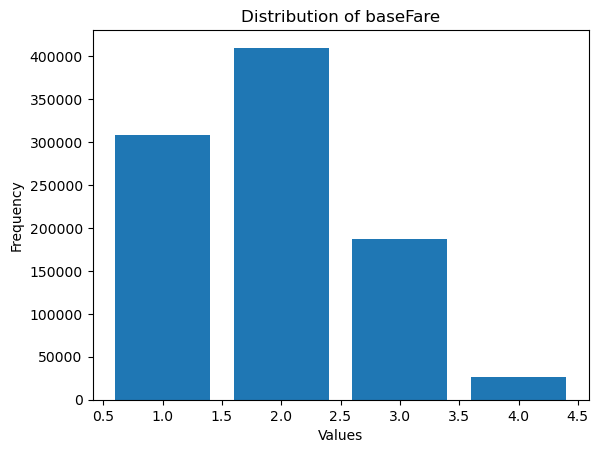

+-------------+------+
|bucketFeature| count|
+-------------+------+
|          1.0|238734|
|          2.0|401230|
|          3.0|231683|
|          4.0| 58445|
|          5.0|  1453|
+-------------+------+



<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Distribution of totalFare')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

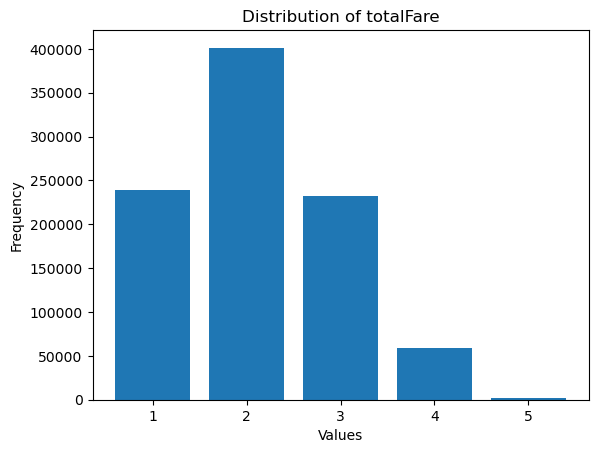

+-------------+------+
|bucketFeature| count|
+-------------+------+
|          1.0| 17235|
|          2.0| 28868|
|          3.0| 57426|
|          4.0|104210|
|          5.0| 98072|
|          6.0| 73568|
|          7.0| 99340|
|          8.0| 56831|
|          9.0| 51893|
|         10.0| 57673|
|         11.0| 35692|
|         12.0| 37197|
|         13.0| 85456|
|         14.0| 62197|
|         15.0| 29317|
|         16.0| 20280|
|         17.0|  7317|
|         18.0|  4708|
|         19.0|  4084|
|         20.0|   181|
+-------------+------+



<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Distribution of totalTravelDistance')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

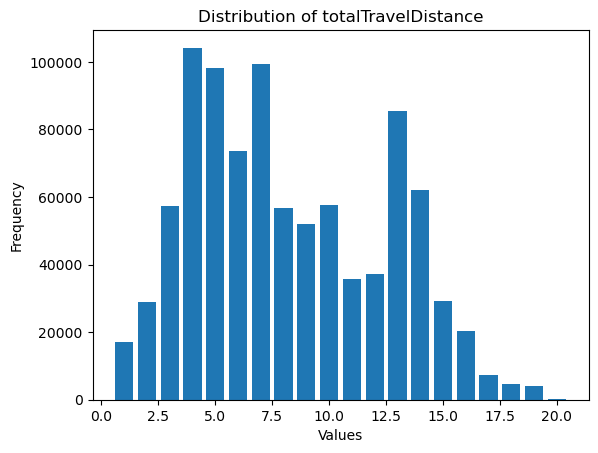

In [12]:
num_buckets = 20
step = 4000 / num_buckets
splits = [float("-inf")] + [i * step for i in range(0, num_buckets)] + [float("inf")]
selected_columns = ['baseFare', 'totalFare','totalTravelDistance']

# Построение гистограммы для каждой колонки
for selected_column in selected_columns:
    bucketizer = Bucketizer(splits=splits, inputCol=selected_column, outputCol="bucketFeature")
    df_bucket = bucketizer.transform(cleaned_dataframe)
    bucket_counts = df_bucket.groupBy("bucketFeature").count().orderBy("bucketFeature")
    bucket_counts.show()
    bucket_counts_pd = bucket_counts.toPandas()
    plt.bar(bucket_counts_pd["bucketFeature"], bucket_counts_pd["count"], align="center", label=selected_column)
    plt.title(f"Distribution of {selected_column}")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()

+-------------+------+
|bucketFeature| count|
+-------------+------+
|          0.0|  3062|
|          1.0|126058|
|          2.0| 86660|
|          3.0| 97349|
|          4.0|130120|
|          5.0|131368|
|          6.0|112637|
|          7.0| 81821|
|          8.0| 60220|
|          9.0| 44701|
|         10.0| 28926|
|         11.0| 18570|
|         12.0|  9591|
|         13.0|   462|
+-------------+------+



<BarContainer object of 14 artists>

Text(0.5, 1.0, 'Distribution of travelDuration')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

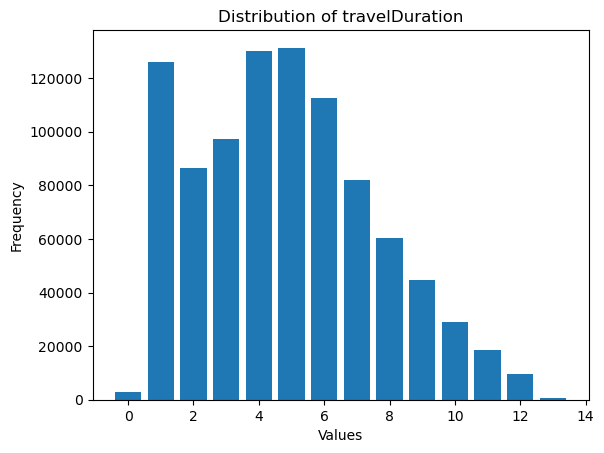

In [13]:
num_buckets = 20
step = 1500 / num_buckets
splits = [float("-inf")] + [i * step for i in range(1, num_buckets)] + [float("inf")]

bucketizer = Bucketizer(splits=splits, inputCol='travelDuration', outputCol="bucketFeature")
df_bucket = bucketizer.transform(cleaned_dataframe)
bucket_counts = df_bucket.groupBy("bucketFeature").count().orderBy("bucketFeature")
bucket_counts.show()
bucket_counts_pd = bucket_counts.toPandas()
plt.bar(bucket_counts_pd["bucketFeature"], bucket_counts_pd["count"], align="center", label='travelDuration')
plt.title(f"Distribution of {'travelDuration'}")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

<BarContainer object of 16 artists>

Text(0.5, 1.0, 'Distribution of startingAirport')

Text(0.5, 0, 'startingAirport')

Text(0, 0.5, 'Count')

<BarContainer object of 16 artists>

Text(0.5, 1.0, 'Distribution of destinationAirport')

Text(0.5, 0, 'destinationAirport')

Text(0, 0.5, 'Count')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Distribution of isNonStop')

Text(0.5, 0, 'isNonStop')

Text(0, 0.5, 'Count')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Distribution of isBasicEconomy')

Text(0.5, 0, 'isBasicEconomy')

Text(0, 0.5, 'Count')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Distribution of isRefundable')

Text(0.5, 0, 'isRefundable')

Text(0, 0.5, 'Count')

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Distribution of seatsRemaining')

Text(0.5, 0, 'seatsRemaining')

Text(0, 0.5, 'Count')

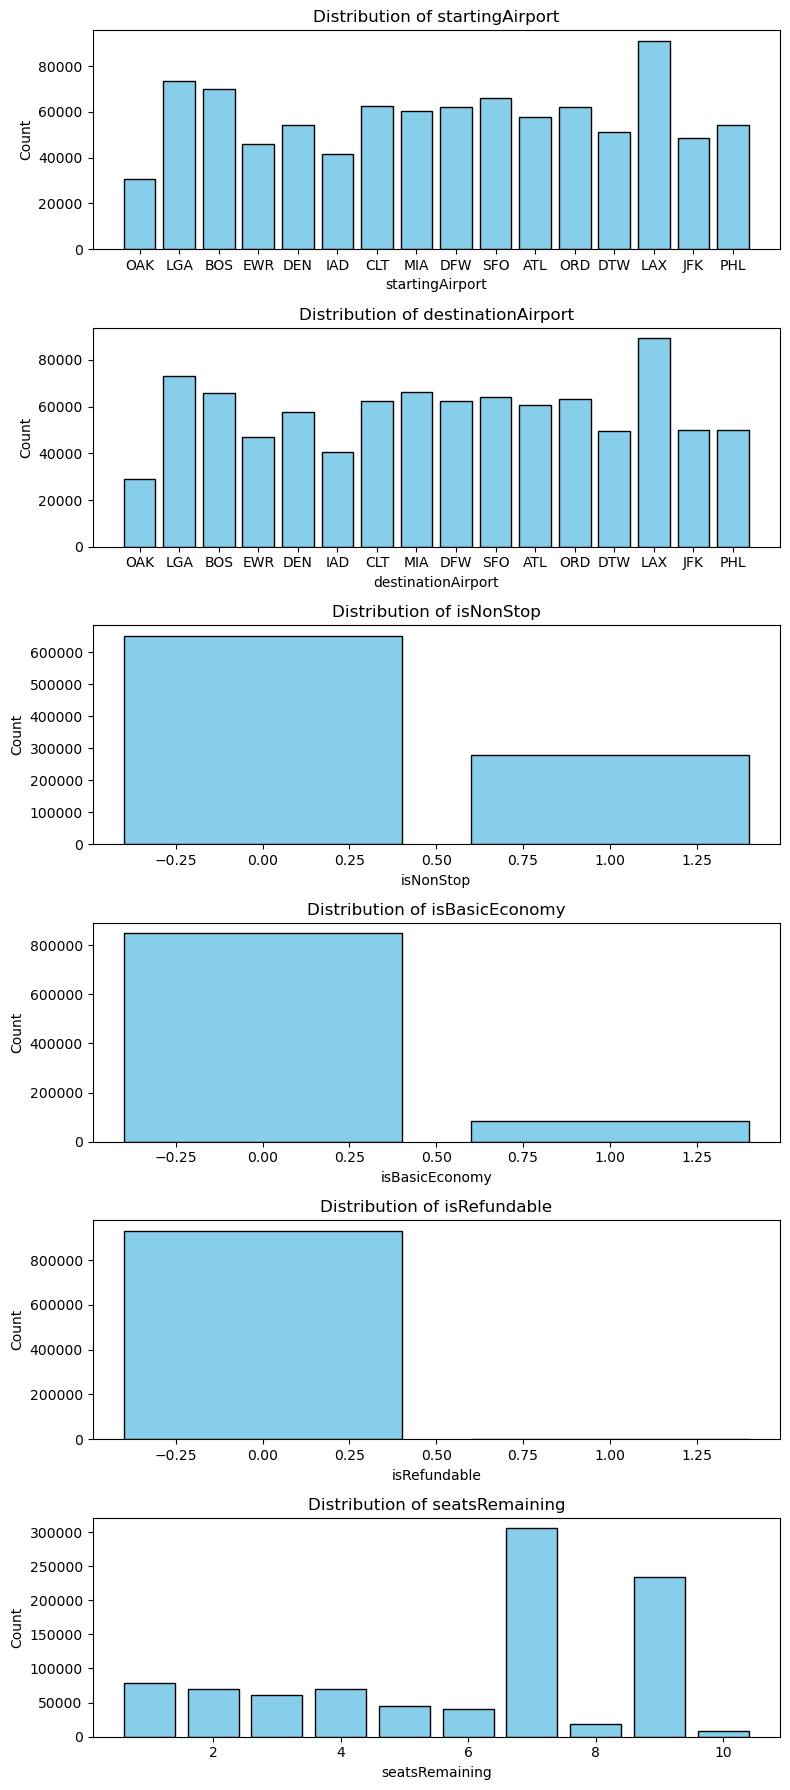

In [14]:
selected_features = ['startingAirport', 'destinationAirport', 'isNonStop',
                    'isBasicEconomy', 'isRefundable', 
                    'seatsRemaining'] 

fig, axs = plt.subplots(len(selected_features), 1, figsize=(8, 3 * len(selected_features)))

# Построение гистограмм для каждого выбранного признака
for i, feature in enumerate(selected_features):
    # Сгруппировать по признаку и подсчитать количество
    data_grouped = cleaned_dataframe.groupBy(feature).count().collect()
    # Извлечение данных для построения графика
    categories = [row[0] for row in data_grouped]
    counts = [row[1] for row in data_grouped]
    axs[i].bar(categories, counts, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')

# Регулировка расположения подграфиков
plt.tight_layout()

# Отображение графика
plt.show()

In [15]:
# Создаем VectorAssembler для объединения признаков в один вектор
feature_cols = ['baseFare', 'totalFare','totalTravelDistance', 'travelDuration']  
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Применяем VectorAssembler к данным
data = vector_assembler.transform(cleaned_dataframe)

# Вычисляем матрицу корреляции
correlation_matrix = Correlation.corr(data, "features").head()
correlation_array = correlation_matrix[0].toArray()

# Выводим матрицу корреляции
correlation_df = pd.DataFrame(correlation_array, columns=feature_cols)

In [16]:
correlation_df.corr()

,baseFare,totalFare,totalTravelDistance,travelDuration
baseFare,1.000000,0.999758,-0.782683,-0.886925
totalFare,0.999758,1.000000,-0.796140,-0.876553
totalTravelDistance,-0.782683,-0.796140,1.000000,0.408005
travelDuration,-0.886925,-0.876553,0.408005,1.000000


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Матрица корреляции признаков')

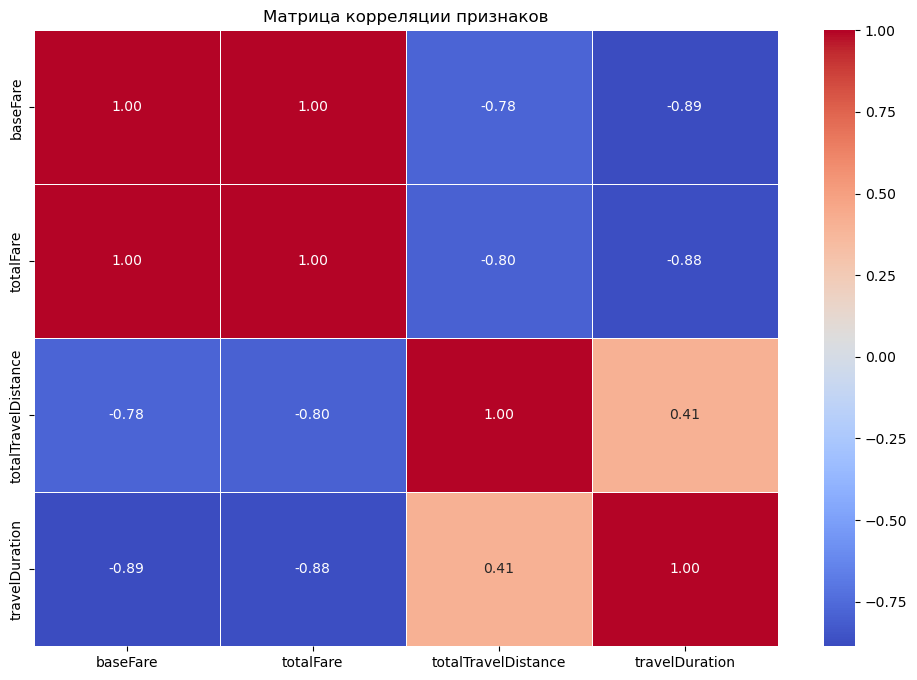

In [17]:
# Строим тепловую карту корреляции с использованием Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции признаков')
plt.show()

In [19]:
cleaned_dataframe.coalesce(1).write.options(header='True', delimiter=';').csv('new_csv')